<a href="https://colab.research.google.com/github/matsunori39/How-Deep-Learning-AI-Works/blob/main/How_Deep_Learning_AI_Works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://info.nikkeibp.co.jp/media/NSW/atcl/books/111100050/

# Chapter 7: Making Sense of Image Recognition AI Code

## 7-2 Prepare training and test data

### Import required modules

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

### Loading training and test data

In [4]:
# image transformation process
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load training data
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

# Load test data
testset = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=2)

# Define class label names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Random display of training data images and labels

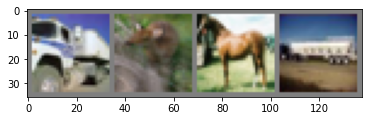

truck  deer horse truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 7-3 Write code to implement CNN

### Implement CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  # Define each layer
  def __init__(self):
      super(Net, self).__init__()

      # Convolutional layer 1
      self.conv1 = nn.Conv2d(3, 6, 5)

      # Pooling layer
      self.pool = nn.MaxPool2d(2, 2)

      # Convolutional layer 2
      self.conv2 = nn.Conv2d(6, 16, 5)

      # Fully-Connected layer
      self.fc1 = nn.Linear(16 * 5 * 5, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84,10)
  
  # Define configuration
  def forward(self, x):
    # conv1 and pool
    x = self.pool(F.relu(self.conv1(x)))

    # conv2 and pool
    x = self.pool(F.relu(self.conv2(x)))

    # Sort for fc
    x = x.view(-1, 16 * 5 * 5)

    # fc1
    x = F.relu(self.fc1(x))

    # fc2
    x = F.relu(self.fc2(x))

    # fc3 to output layer
    x = self.fc3(x)


# Generate CNN
net = Net()